# IDATT2502 Project 2024
## Predicting stock market sentiment

Libray Import

In [137]:
# General Libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Text Processing Libraries
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import contractions

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
)
from sklearn.preprocessing import MaxAbsScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# Suppress warnings
warnings.filterwarnings('ignore')


## Loading News dataset

In [138]:
# Load each CSV file and specify the correct column names
guardian_news = pd.read_csv('data/guardian_headlines.csv', names=['Time', 'Headline'], header=0)
reuters_news = pd.read_csv('data/reuters_headlines.csv', names=['Headline', 'Time', 'Description'], header=0)
cnbc_news = pd.read_csv('data/cnbc_headlines.csv', names=['Headline', 'Time', 'Description'], header=0)

# Add Source column to identify each news source
guardian_news['Source'] = 'Guardian'
reuters_news['Source'] = 'Reuters'
cnbc_news['Source'] = 'CNBC'

# Convert 'Time' to a consistent date format
guardian_news['Date'] = pd.to_datetime(guardian_news['Time'], errors='coerce').dt.date
reuters_news['Date'] = pd.to_datetime(reuters_news['Time'], errors='coerce').dt.date
cnbc_news['Date'] = pd.to_datetime(cnbc_news['Time'], errors='coerce').dt.date

# Keep only the required columns: 'Date', 'Headline', 'Source', and 'Description' (if available)
guardian_news = guardian_news[['Date', 'Headline', 'Source']]
reuters_news = reuters_news[['Date', 'Headline', 'Source', 'Description']]
cnbc_news = cnbc_news[['Date', 'Headline', 'Source', 'Description']]

# Concatenate all news data into a single DataFrame
all_news = pd.concat([guardian_news, reuters_news, cnbc_news], ignore_index=True)

# Group by 'Date' and aggregate headlines and descriptions for each source
# Aggregating headlines and descriptions by joining them with " | " if multiple entries exist for the same date
combined_news = all_news.groupby(['Date', 'Source'], as_index=False).agg({
    'Headline': lambda x: ' | '.join(x.dropna()),  # Combine multiple headlines
    'Description': lambda x: ' | '.join(x.dropna()) if 'Description' in x else None
})

# Pivot to have each source as a separate column
news_pivot = combined_news.pivot(index='Date', columns='Source', values=['Headline', 'Description'])

# Flatten the multi-index columns and rename for clarity
news_pivot.columns = [f"{col[0]}_{col[1]}" for col in news_pivot.columns]
news_pivot = news_pivot.reset_index()

news_pivot.head()
# Assuming you have the 'news_pivot' DataFrame from previous steps

# Fill NaN values with empty strings
news_pivot = news_pivot.fillna('')

# Combine headlines and descriptions into single text columns for each source
news_pivot['Guardian_Text'] = news_pivot['Headline_Guardian']
if 'Description_Guardian' in news_pivot.columns:
    news_pivot['Guardian_Text'] += ' ' + news_pivot['Description_Guardian']

news_pivot['CNBC_Text'] = news_pivot['Headline_CNBC']
if 'Description_CNBC' in news_pivot.columns:
    news_pivot['CNBC_Text'] += ' ' + news_pivot['Description_CNBC']

news_pivot['Reuters_Text'] = news_pivot['Headline_Reuters']
if 'Description_Reuters' in news_pivot.columns:
    news_pivot['Reuters_Text'] += ' ' + news_pivot['Description_Reuters']

# Combine all sources into a single text column
news_pivot['Combined_Text'] = (
        news_pivot['Guardian_Text'] + ' ' +
        news_pivot['CNBC_Text'] + ' ' +
        news_pivot['Reuters_Text']
)
news_pivot.head()

,Date,Headline_CNBC,Headline_Guardian,Headline_Reuters,Description_CNBC,Description_Guardian,Description_Reuters,Guardian_Text,CNBC_Text,Reuters_Text,Combined_Text
0,2017-12-17,,Peter Preston on press and broadcasting \n\n\...,,,,,Peter Preston on press and broadcasting \n\n\...,,,Peter Preston on press and broadcasting \n\n\...
1,2017-12-18,,France saves Marquis de Sade’s 120 Days of Sod...,,,,,France saves Marquis de Sade’s 120 Days of Sod...,,,France saves Marquis de Sade’s 120 Days of Sod...
2,2017-12-19,,House prices to fall in London and south-east ...,,,,,House prices to fall in London and south-east ...,,,House prices to fall in London and south-east ...
3,2017-12-20,,Hedge funds fail to stop 'billion-dollar brain...,,,,,Hedge funds fail to stop 'billion-dollar brain...,,,Hedge funds fail to stop 'billion-dollar brain...
4,2017-12-21,,Guardian Brexit watch \n\n\n Brexit helped p...,,,,,Guardian Brexit watch \n\n\n Brexit helped p...,,,Guardian Brexit watch \n\n\n Brexit helped p...


## NLP methods

In [139]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) - {'not', 'no', 'nor', 'never'}

def get_wordnet_pos(word):
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {'J': wordnet.ADJ,
                'N': wordnet.NOUN,
                'V': wordnet.VERB,
                'R': wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_text(text):
    if pd.isnull(text):
        return ''
    # Lowercase
    text = text.lower()
    # Expand contractions
    text = contractions.fix(text)
    # Remove punctuation (except numbers)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # POS tagging and lemmatize
    tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]
    # Join tokens back into string
    processed_text = ' '.join(tokens)
    return processed_text



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/johanneslorentzen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/johanneslorentzen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/johanneslorentzen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/johanneslorentzen/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Downloading S&P500 market data

using open-source libray yfinance to collect market data from yahoo finance

In [140]:
start_date = "2017-12-17"
end_date = "2020-07-19"

# Download the stock data
stock_data = yf.download('SPY', start=start_date, end=end_date, multi_level_index = False)

# Convert the index to datetime.date if needed
stock_data.index = pd.to_datetime(stock_data.index).date

# Sort by the index (dates)
stock_data = stock_data.sort_index()

# Proceed with your calculations
# For example, calculate daily price change
stock_data['Price_Change'] = stock_data['Close'].diff()

# Define the target variable
stock_data['Target'] = (stock_data['Price_Change'] > 0).astype(int)

# If you need to merge with another DataFrame, reset the index
stock_data.reset_index(inplace=True)
stock_data.rename(columns={'index': 'Date'}, inplace=True)

stock_data.head()


[*********************100%***********************]  1 of 1 completed


,Date,Adj Close,Close,High,Low,Open,Volume,Price_Change,Target
0,2017-12-18,240.290894,268.200012,268.600006,267.980011,268.100006,83653600,NaN,0
1,2017-12-19,239.368088,267.170013,268.529999,267.089996,268.480011,82382900,-1.029999,0
2,2017-12-20,239.242599,267.029999,268.329987,266.690002,268.269989,76751500,-0.140015,0
3,2017-12-21,239.735336,267.579987,268.390015,267.299988,267.739990,67032300,0.549988,1
4,2017-12-22,239.672729,267.510010,267.640015,266.899994,267.600006,78720900,-0.069977,0


## Combining the refined data and adding sentiment

In [141]:
# After filling NaNs
news_pivot = news_pivot.fillna('')

# Combine text for Guardian
news_pivot['Guardian_Text'] = news_pivot['Headline_Guardian']

# Combine text for Reuters and CNBC (with descriptions if available)
news_pivot['Reuters_Text'] = news_pivot['Headline_Reuters']
news_pivot['CNBC_Text'] = news_pivot['Headline_CNBC']

# Combine all sources
news_pivot['Combined_Text'] = (
    news_pivot['Guardian_Text'] + ' ' +
    news_pivot['CNBC_Text'] + ' ' +
    news_pivot['Reuters_Text']
)

# Preprocess text
news_pivot['Processed_Text'] = news_pivot['Combined_Text'].apply(preprocess_text)

# Define processed_news
processed_news = news_pivot[['Date', 'Processed_Text']]

# Ensure dates are datetime objects
processed_news['Date'] = pd.to_datetime(processed_news['Date'])
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Merge datasets
combined_news_stock = pd.merge(processed_news, stock_data[['Date', 'Target']].dropna(), on='Date', how='inner').dropna()
sia = SentimentIntensityAnalyzer()
combined_news_stock['Sentiment'] = combined_news_stock['Processed_Text'].apply(lambda x: sia.polarity_scores(x)['compound'])
combined_news_stock.head()

,Date,Processed_Text,Target,Sentiment
0,2017-12-18,france save marquis de sade 120 day sodom auct...,0,-0.9607
1,2017-12-19,house price fall london southeast 2018 say sur...,0,-0.9623
2,2017-12-20,hedge fund fail stop billiondollar brain city ...,0,-0.7184
3,2017-12-21,guardian brexit watch brexit help push living ...,1,0.8176
4,2017-12-22,steelworker face huge pension cut tata complet...,0,0.6642


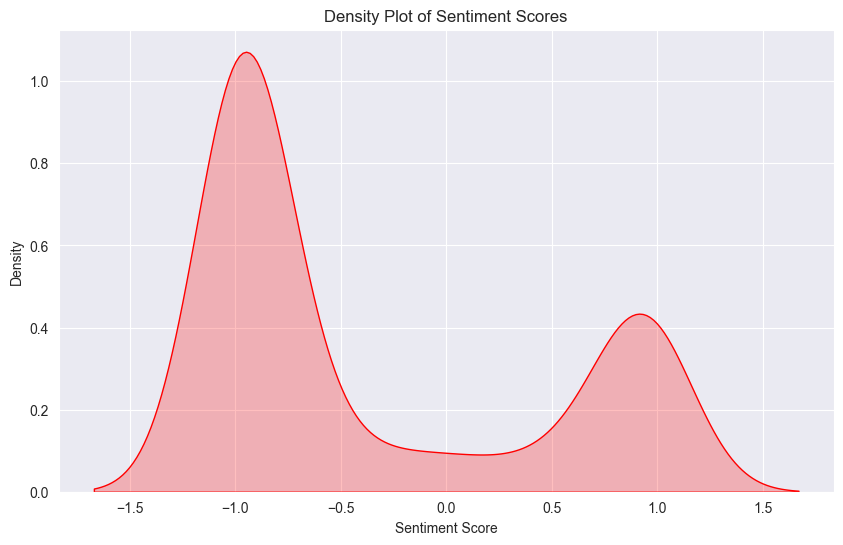

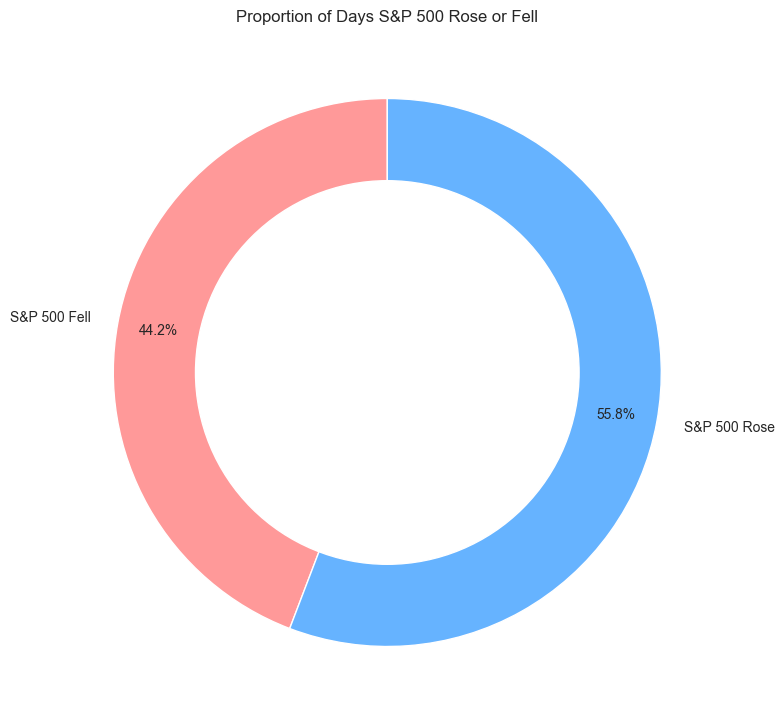

In [142]:
# Density Plot
plt.figure(figsize=(10,6))
sns.kdeplot(combined_news_stock['Sentiment'], shade=True, color='red')
plt.title('Density Plot of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.show()

# Count occurrences of each target class
target_counts = combined_news_stock['Target'].value_counts().sort_index()

# Labels based on your encoding (0: Fell, 1: Rose)
labels = ['S&P 500 Fell', 'S&P 500 Rose']

# Colors for the chart
colors = ['#ff9999','#66b3ff']

# Create the pie chart
plt.figure(figsize=(8,8))
plt.pie(target_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85)

# Draw a circle in the center to make it a donut chart
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Proportion of Days S&P 500 Rose or Fell')
plt.tight_layout()
plt.show()


# Random Forrest Classifier

Fitting 5 folds for each of 648 candidates, totalling 3240 fits

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.32      0.44        57
           1       0.63      0.90      0.74        73

    accuracy                           0.65       130
   macro avg       0.67      0.61      0.59       130
weighted avg       0.67      0.65      0.61       130



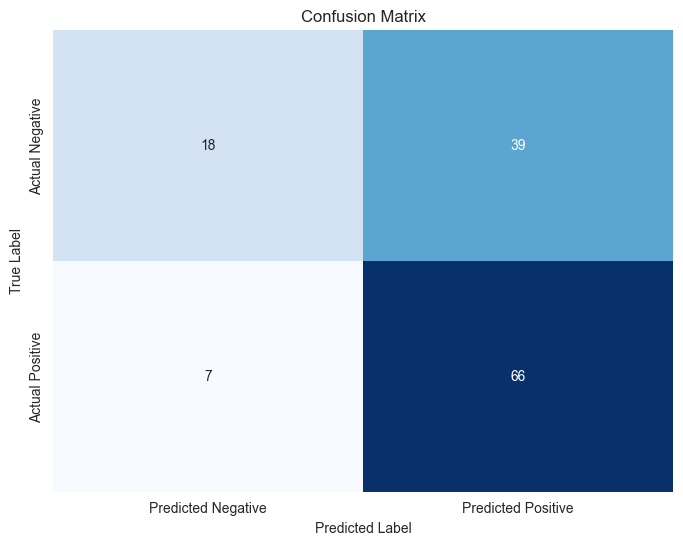

Accuracy Score: 0.6461538461538462
ROC AUC Score: 0.7164143234799327


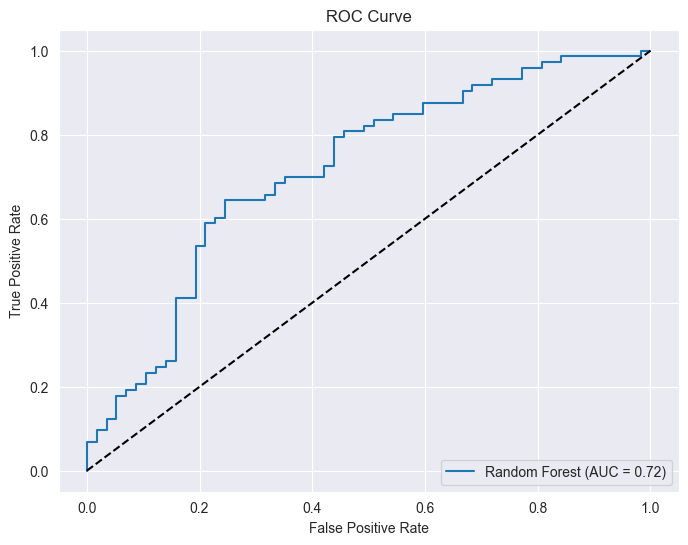

Training feature matrix shape: (517, 10001)
Testing feature matrix shape: (130, 10001)
Training target vector shape: (517,)
Testing target vector shape: (130,)


In [143]:
# Prepare Data for Modeling
# Features and target variable
X_text = combined_news_stock['Processed_Text']
y = combined_news_stock['Target']
sentiment = combined_news_stock['Sentiment'].values.reshape(-1, 1)

# Split the data into training and testing sets with stratification
X_train_text, X_test_text, y_train, y_test, sentiment_train, sentiment_test = train_test_split(
    X_text, y, sentiment, test_size=0.2, random_state=42, stratify=y)

# Initialize the vectorizer with optimized parameters
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

# Fit the vectorizer on the training data and transform
X_train_vect = vectorizer.fit_transform(X_train_text)

# Transform the test data
X_test_vect = vectorizer.transform(X_test_text)

# Combine text features with sentiment scores
from scipy.sparse import hstack

X_train = hstack([X_train_vect, sentiment_train])
X_test = hstack([X_test_vect, sentiment_test])
model = RandomForestClassifier()
model_params ={
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]

}
model_search = GridSearchCV(
    estimator=model,
    param_grid=model_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

model_search.fit(X_train, y_train)
best_params = model_search.best_params_
model = RandomForestClassifier(**best_params, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Probability estimates for ROC AUC

# Evaluate the model

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
    xticklabels=['Predicted Negative', 'Predicted Positive'],
    yticklabels=['Actual Negative', 'Actual Positive']
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Accuracy Score
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC AUC Score:", roc_auc)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


# Check the shapes
print("Training feature matrix shape:", X_train.shape)
print("Testing feature matrix shape:", X_test.shape)
print("Training target vector shape:", y_train.shape)
print("Testing target vector shape:", y_test.shape)

# KNN Classifier Model

## Logistic Regression Model

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters for Logistic Regression: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l1'}

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.47      0.51        57
           1       0.63      0.70      0.66        73

    accuracy                           0.60       130
   macro avg       0.59      0.59      0.59       130
weighted avg       0.60      0.60      0.60       130



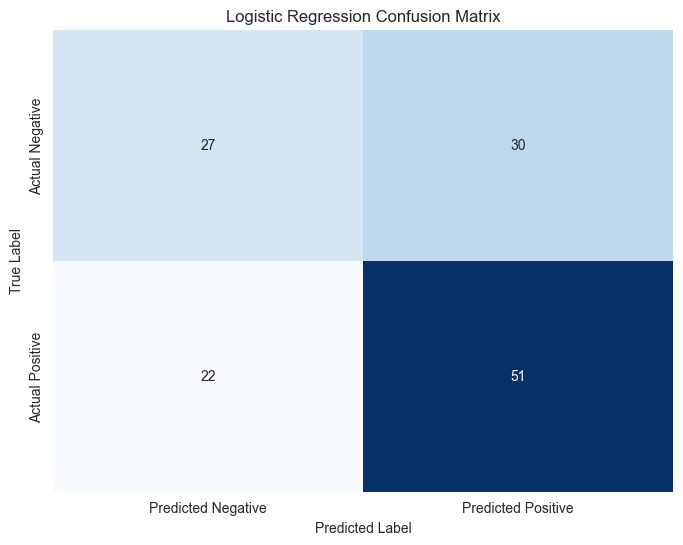

Logistic Regression Accuracy Score: 0.6
Logistic Regression ROC AUC Score: 0.6440759432828647


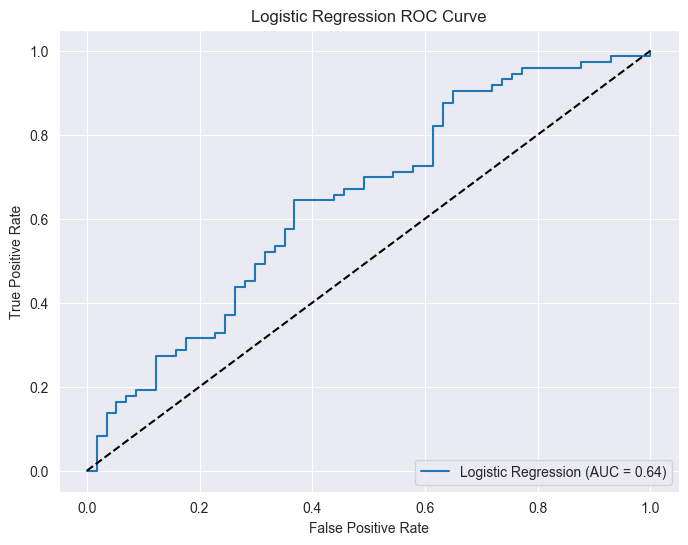

In [144]:
# Define the model and parameter grid
logreg_model = LogisticRegression(solver='liblinear', random_state=42)
logreg_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'class_weight': [None, 'balanced']
}

# Perform grid search
logreg_grid_search = GridSearchCV(
    estimator=logreg_model,
    param_grid=logreg_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit the model
logreg_grid_search.fit(X_train_scaled, y_train)
logreg_best_params = logreg_grid_search.best_params_
print("Best parameters for Logistic Regression:", logreg_best_params)

# Use the best estimator
logreg_best_model = logreg_grid_search.best_estimator_

# Make predictions
y_pred_logreg = logreg_best_model.predict(X_test_scaled)
y_prob_logreg = logreg_best_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model

# Classification Report
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logreg))

# Confusion Matrix
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix_logreg, annot=True, fmt='d', cmap='Blues', cbar=False,
    xticklabels=['Predicted Negative', 'Predicted Positive'],
    yticklabels=['Actual Negative', 'Actual Positive']
)
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Accuracy Score
print("Logistic Regression Accuracy Score:", accuracy_score(y_test, y_pred_logreg))

# ROC AUC Score
roc_auc_logreg = roc_auc_score(y_test, y_prob_logreg)
print("Logistic Regression ROC AUC Score:", roc_auc_logreg)

# ROC Curve
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_test, y_prob_logreg)
plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, label=f"Logistic Regression (AUC = {roc_auc_logreg:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Logistic Regression ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

## MultinomialNB Model

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters for MultinomialNB: {'alpha': 0.1, 'fit_prior': False}

MultinomialNB Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.44      0.47        57
           1       0.60      0.67      0.64        73

    accuracy                           0.57       130
   macro avg       0.56      0.55      0.55       130
weighted avg       0.56      0.57      0.56       130



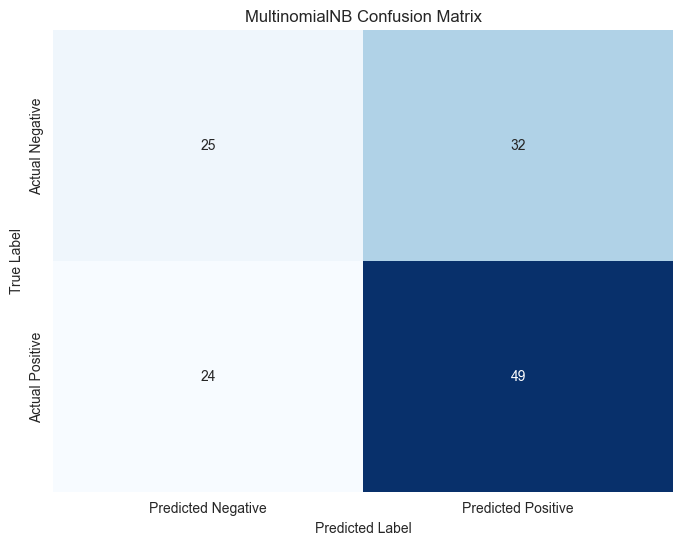

MultinomialNB Accuracy Score: 0.5692307692307692
MultinomialNB ROC AUC Score: 0.581350636866138


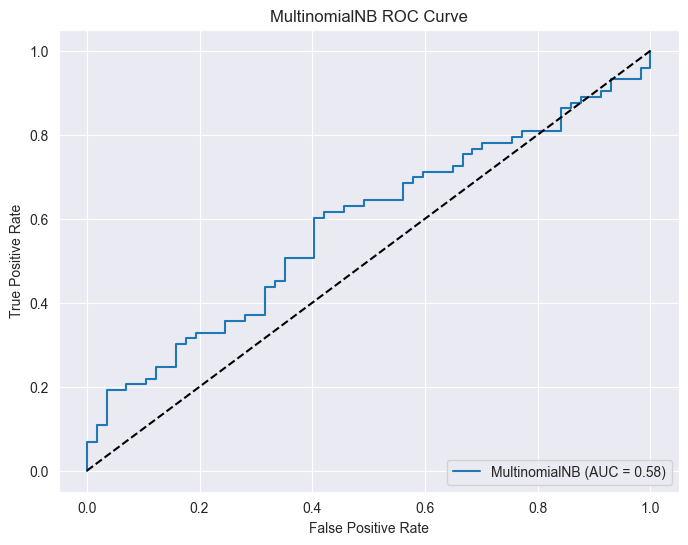

In [145]:
X_train_nb = X_train_vect
X_test_nb = X_test_vect

# Define the model and parameter grid
nb_model = MultinomialNB()
nb_params = {
    'alpha': [0.1, 0.5, 1.0],
    'fit_prior': [True, False]
}

# Perform grid search
nb_grid_search = GridSearchCV(
    estimator=nb_model,
    param_grid=nb_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit the model
nb_grid_search.fit(X_train_nb, y_train)
nb_best_params = nb_grid_search.best_params_
print("Best parameters for MultinomialNB:", nb_best_params)

# Use the best estimator
nb_best_model = nb_grid_search.best_estimator_

# Make predictions
y_pred_nb = nb_best_model.predict(X_test_nb)
y_prob_nb = nb_best_model.predict_proba(X_test_nb)[:, 1]

# Evaluate the model

# Classification Report
print("\nMultinomialNB Classification Report:")
print(classification_report(y_test, y_pred_nb))

# Confusion Matrix
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix_nb, annot=True, fmt='d', cmap='Blues', cbar=False,
    xticklabels=['Predicted Negative', 'Predicted Positive'],
    yticklabels=['Actual Negative', 'Actual Positive']
)
plt.title('MultinomialNB Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Accuracy Score
print("MultinomialNB Accuracy Score:", accuracy_score(y_test, y_pred_nb))

# ROC AUC Score
roc_auc_nb = roc_auc_score(y_test, y_prob_nb)
print("MultinomialNB ROC AUC Score:", roc_auc_nb)

# ROC Curve
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, y_prob_nb)
plt.figure(figsize=(8, 6))
plt.plot(fpr_nb, tpr_nb, label=f"MultinomialNB (AUC = {roc_auc_nb:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title('MultinomialNB ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()